In [1]:
from subprocess import check_output
import os
import pandas as pd
import numpy as np
import scipy.stats as stats
import pybedtools
import logging
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, accuracy_score, recall_score
from sklearn.metrics import auc
from pybedtools.featurefuncs import midpoint
import pickle as pkl

logging.basicConfig(level='WARNING')

np.random.seed(1234)
window = 1e6


# no overlap for enhancer and promoter: no need
# distance of two interval is define as diff of two border: dist between two mid
# enhancer find -> prmoter or inverse?: promoter -> enhancer
# corr must be positive?: yes

def enhancer_1M_gene():
    if not os.path.exists('1mgene.pkl'):
        e2g = dict()
        en = pybedtools.BedTool('./data/enhancer_region.bed')
        pr = pybedtools.BedTool('./data/promoter_region.bed')
        win_e = en.window(pr, w=window)
        df = win_e.to_dataframe()

        ens = df['name'].drop_duplicates().values
        for e in ens:
            e2g[e] = df[df['name'] == e]['blockCount'].drop_duplicates().values.tolist()
        with open('1mgene.pkl', 'wb') as f:
            pkl.dump(e2g, f)
    else:
        with open('1mgene.pkl', 'rb') as f:
            e2g = pkl.load(f)
    return e2g


e2g = enhancer_1M_gene()


def normalize(X, column_sample=True):
    if column_sample:
        view_m = X.mean(axis=1)
        view = (X.T - view_m).T

        view_norm = np.linalg.norm(view, axis=1, ord=2)
        view_norm[view_norm == 0] = 1
        view = (view.T / (view_norm + 1e-8)).T
        return view


def gen_nearest():
    '''find the nearest promoter for each enhancer

    :return:
    '''

    # bedtools intersect -a enhancer_region.bed -b promoter_region.bed -wb
    # window

    en = pybedtools.BedTool('./data/enhancer_region.bed')
    pr = pybedtools.BedTool('./data/promoter_region.bed')
    # mid_en = en.each(midpoint).saveas()
    # mid_pr = pr.each(midpoint).saveas()

    mid_en = en
    mid_pr = pr

    nearest = mid_en.sort().closest(mid_pr.sort(), d=True)
    nearest = nearest.filter(lambda x: x[3] in e2g.keys()).saveas()
    nearest = nearest.filter(lambda x: x[-4] in e2g[x[3]]).saveas()

    df = nearest.to_dataframe().iloc[:, [3, 9, 12]]

    df.columns = ['enhancer', 'promoter', 'dist']
    df = df.drop_duplicates('enhancer')
    df = df.set_index('enhancer')
    df.to_csv('./data/closest_promoter.txt', sep='\t', index=True, header=False)
    return df


def gen_maxcor():
    promoter = pd.read_csv('./data/promoter_signal.matrix', sep='\t', header=0, index_col=0).astype(float)
    enhancer = pd.read_csv('./data/enhancer_signal.quantile_normalized.matrix', sep='\t', header=0, index_col=0).astype(
        float)
    pM = normalize(promoter.values)
    eM = normalize(enhancer.values)
    corrM = eM.dot(pM.T)
    df2 = pd.DataFrame(corrM, index=enhancer.index, columns=promoter.index)

    # filtering
    pairs = []
    for en in df2.index:
        try:
            s = df2.loc[en][e2g[en]]
        except KeyError:
            logging.warning('Missing gene %s in 1MB windows enhancer file' % en)
            continue

        s = s[~np.isnan(s.values)]
        if s.shape[0] > 0:
            gene = df2.loc[en][e2g[en]].idxmax()
            score = df2.loc[en, gene]
            if score > 0:
                pairs.append([en, gene, score])
    df2 = pd.DataFrame(pairs)
    df2.to_csv('./data/maxcor_promoter.txt', sep='\t', index=False, header=False)
    return df2


def gen_random(seed=1234):
    np.random.seed(seed)
    pairs = []

    for en, v in e2g.items():
        gene = np.random.choice(v)
        pairs.append([en, gene])

    df3 = pd.DataFrame(pairs)
    df3.loc[:, 2] = np.random.rand(df3.shape[0])
    df3.to_csv('./data/random_promoter.txt', sep='\t', index=False, header=False)
    return df3


def gen_result(labelset, predict_dir):
    # nearest = gen_nearest()
    # maxcor = gen_maxcor()
    # rand = gen_random()


    if labelset == 'gtex':
        tissue_map = pd.read_csv('./data/FANTOM_GTEx_tissue_match.csv', sep=',', index_col=None, header=0)
    elif labelset == 'ng2019':
        tissue_map = pd.read_excel('./data/ng2019_hic/tissue_match.xlsx', sheet_name='Sheet2')
        tissue_map = tissue_map.dropna()
    else:
        raise NotImplementedError

    nearest = pd.read_csv('./data/closest_promoter.txt', sep='\t', index_col=0, header=None)
    maxcor = pd.read_csv('./data/maxcor_promoter.txt', sep='\t', index_col=0, header=None)
    rand = pd.read_csv('./data/random_promoter.txt', sep='\t', index_col=0, header=None)

    nearest.columns = ['promoter', 'score']
    maxcor.columns = ['promoter', 'score']
    rand.columns = ['promoter', 'score']

    # to confirm
    # at present only consider GTEx mapped: yes
    # keep the entry with max score: comfirmed
    # do not need to consider snp overlap? directly match?: yes

    matched_tissue_auprs = dict()
    related_tissue_auprs = dict()

    # for row in tissue_map.index:
    #     tissue = tissue_map.loc[row]['GTEx_name']
    #     ismatched = True if tissue_map.loc[row]['Match_type'] == 'Match' else False
    #     if ismatched:
    #         matched_tissue_auprs[tissue] = []
    #     else:
    #         related_tissue_auprs[tissue] = []

    for row in tissue_map.index:
        if labelset == 'gtex':
            fantom_ids = [tissue_map.loc[row]['FANTOM_ID']]
            tissue = tissue_map.loc[row]['GTEx_name']
            ismatched = True if tissue_map.loc[row]['Match_type'] == 'Match' else False

            label = pd.read_csv('./data/eQTL_link/%s.eQTL_link.txt' % tissue, sep='\t', index_col=None, header=None)
            label.columns = ['promoter', 'enhancer']
            label = label.set_index('enhancer')

        else:
            fantom_ids = [tissue_map.loc[row]['FANTOM_ID']]
            tissue = tissue_map.loc[row]['pcHiC_name']
            ismatched = True if tissue_map.loc[row]['Match_type'] == 'Match' else False

            label = pd.read_csv('./data/ng2019_hic/ng2019_link/%s_link.txt' % tissue, sep='\t', index_col=None,
                                header=None)
            label.columns = ['promoter', 'enhancer']
            label = label.set_index('enhancer')

        df = pd.DataFrame()
        for file in fantom_ids:
            # df = df.append(
            #     pd.read_csv('./data/link.aggregated/%s.txt' % file, sep='\t', index_col=None, header=None))
            df = df.append(
                pd.read_csv(os.path.join(predict_dir, '%s.txt' % file), sep='\t', index_col=None, header=None))

        df = df.reset_index(drop=True)
        df.columns = ['promoter', 'enhancer', 'score']

        df = df.sort_values(by=['enhancer', 'score'], ascending=[True, False], kind='mergesort')
        df = df.drop_duplicates(subset='enhancer', keep='first')
        df = df[df['score'] > 0]  # filtering
        df = df.set_index('enhancer')

        # active enhancer
        act_en = pd.DataFrame()
        for file in fantom_ids:
            act_en = act_en.append(
                pd.read_csv('./data/enhancer_usage.aggregated/%s.txt' % file, sep='\t', index_col=None, header=None))
        act_en = act_en[act_en.iloc[:, 1] == 1].iloc[:, 0].drop_duplicates().values
        # need to intersect all?: yep
        # only promoter exist in eQTL are consider for further calculation

        # intersection to label
        # our = df[[(i in label.index) and (i in act_en) for i in df.index]]
        # near = nearest[[(i in label.index) and (i in act_en) for i in nearest.index]]
        # mcor = maxcor[[(i in label.index) and (i in act_en) for i in maxcor.index]]
        # rd = rand[[(i in label.index) and (i in act_en) for i in rand.index]]

        our = df[[(i in label.index) for i in df.index]]
        near = nearest[[(i in label.index) for i in nearest.index]]
        mcor = maxcor[[(i in label.index) for i in maxcor.index]]
        rd = rand[[(i in label.index) for i in rand.index]]

        if our.shape[0] == 0:
            logging.warning('no overlaped enhancer for tissue: %s' % tissue)
            continue

        near['score'] = -near['score']

        pres = [our, near, mcor, rd]
        auprs = []
        for pre in pres:
            for i in range(pre.shape[0]):
                ind = pre.index[i]
                if pre.loc[ind]['promoter'] in label[label.index == ind]['promoter'].values:
                    pre.loc[ind, 'confirm'] = True
                else:
                    pre.loc[ind, 'confirm'] = False

            prec, rec, thr = precision_recall_curve(pre['confirm'].astype(np.bool).values, pre['score'].values)
            auprs.append(auc(rec, prec))
        if ismatched:
            matched_tissue_auprs[tissue + '-' + fantom_ids[0]] = auprs
        else:
            related_tissue_auprs[tissue + '-' + fantom_ids[0]] = auprs
    return matched_tissue_auprs, related_tissue_auprs


In [2]:
# %matplotlib notebook
%matplotlib inline

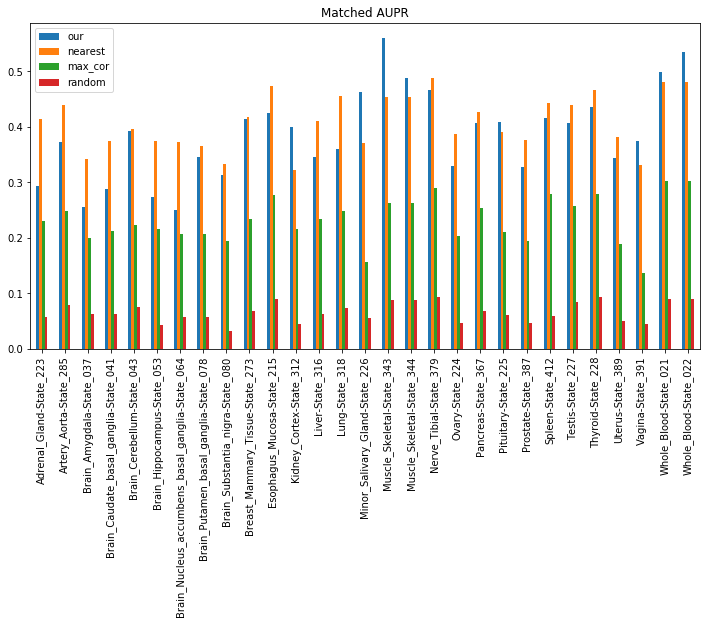

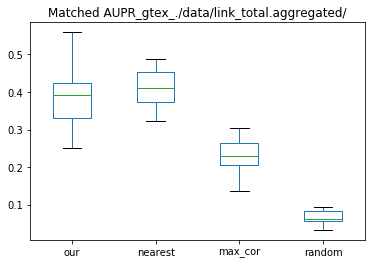

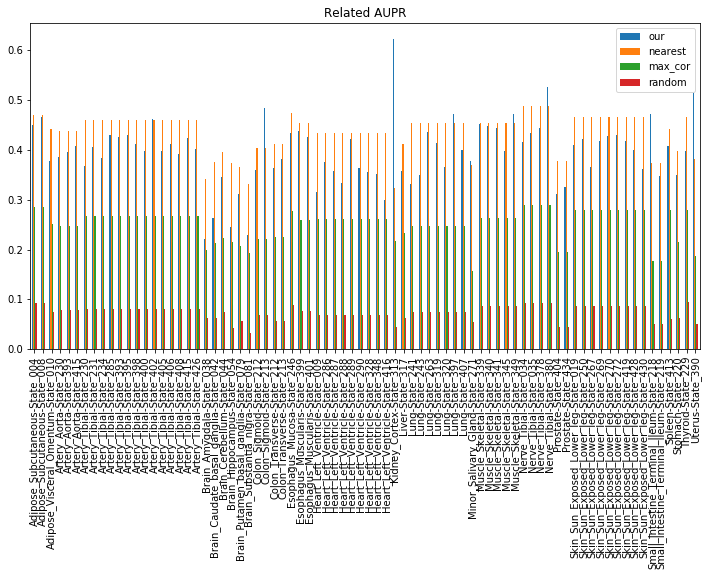

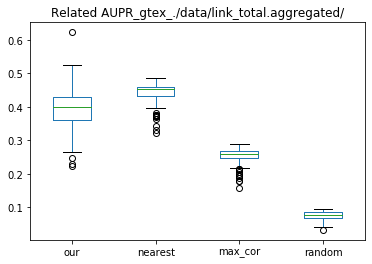

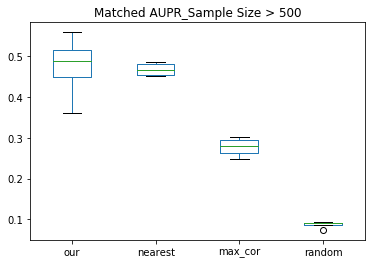

/home1/alfred/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [14]:
# labelset = 'ng2019' # Hi-C
labelset = 'gtex' #eQTL
predict_dir = './data/link_total.aggregated/'

# matched_tissue_auprs1, related_tissue_auprs1 = gen_result(labelset, predict_dir)
# yerr = []
for name, auprs in zip(['Matched AUPR', 'Related AUPR'], [matched_tissue_auprs1, related_tissue_auprs1]):
    df = pd.DataFrame(auprs, index=['our', 'nearest', 'max_cor', 'random']).transpose()
    df.plot.bar(title=name, figsize=[12, 6])
    ax = df.plot.box(title='_'.join([name, labelset, predict_dir]))

if labelset == 'gtex':
    tissue_map = pd.read_csv('./data/FANTOM_GTEx_tissue_match.csv', sep=',', index_col=None, header=0)
    name, auprs = 'Matched AUPR', matched_tissue_auprs1
    df = pd.DataFrame(auprs, index=['our', 'nearest', 'max_cor', 'random']).transpose()

    b = 500

    inx_bb = tissue_map[tissue_map['Sample_size'] > b]['FANTOM_ID'].to_list()
    inx_bb = [True if i.split('-')[-1] in inx_bb else False for i in df.index]

    df.loc[inx_bb].plot.box(title=name + '_Sample Size > %d' % b)
    plt.show()

    import scipy
    scipy.stats.wilcoxon(df.loc[inx_bb]['our'].values, y=df.loc[inx_bb]['nearest'].values, alternative='greater')
    
    df.loc[inx_bb].to_csv('./data/link_total_gtex_matched_greterthan500.txt', sep='\t', index=True, header=True)


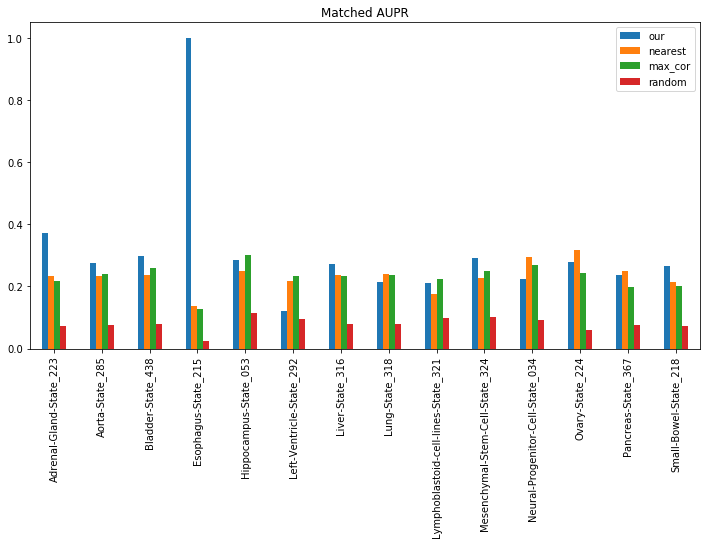

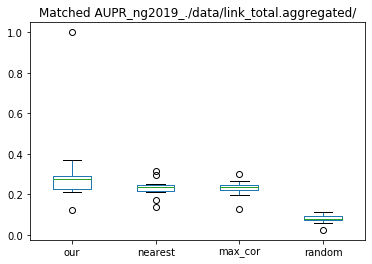

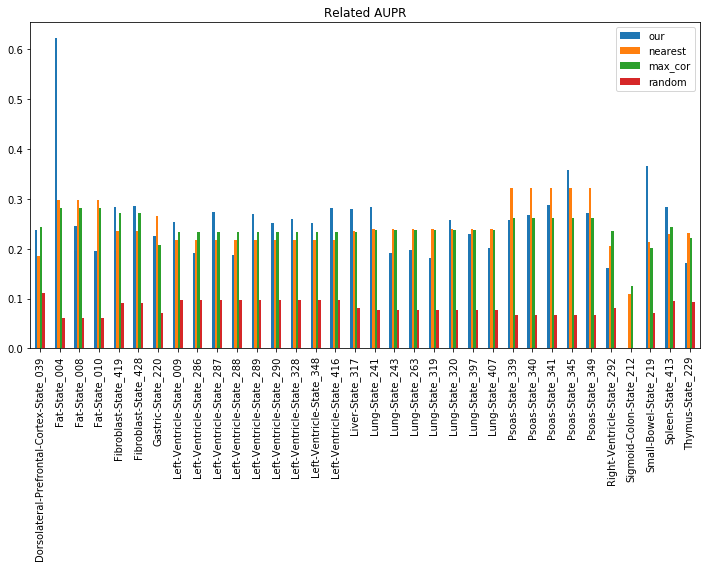

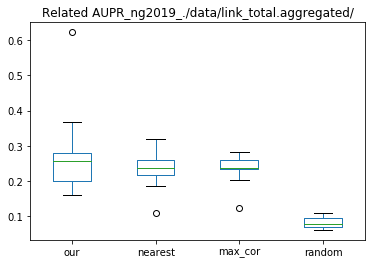

In [15]:
labelset = 'ng2019' # Hi-C
# labelset = 'gtex' #eQTL
predict_dir = './data/link_total.aggregated/'

# matched_tissue_auprs2, related_tissue_auprs2 = gen_result(labelset, predict_dir)
# yerr = []
for name, auprs in zip(['Matched AUPR', 'Related AUPR'], [matched_tissue_auprs2, related_tissue_auprs2]):
    df = pd.DataFrame(auprs, index=['our', 'nearest', 'max_cor', 'random']).transpose()
    df.plot.bar(title=name, figsize=[12, 6])
    ax = df.plot.box(title='_'.join([name, labelset, predict_dir]))

    
# df = pd.DataFrame(matched_tissue_auprs2, index=['our', 'nearest', 'max_cor', 'random']).transpose()
# df.to_csv('./data/link_total_hic_matched.txt', sep='\t', index=True, header=True)